# Human Thermography Evaluation

This notebook compares two human evaluation techniques presented in the literature, Gonzalez and Keyserlingk scores, agains a fully subjective evaluation.

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Load-Data" data-toc-modified-id="Load-Data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Load Data</a></span></li><li><span><a href="#Analysis" data-toc-modified-id="Analysis-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Analysis</a></span><ul class="toc-item"><li><span><a href="#Correlation" data-toc-modified-id="Correlation-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Correlation</a></span></li><li><span><a href="#Combined-Evaluations" data-toc-modified-id="Combined-Evaluations-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Combined Evaluations</a></span></li><li><span><a href="#Thermal-Scores" data-toc-modified-id="Thermal-Scores-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Thermal Scores</a></span></li></ul></li><li><span><a href="#Score-correlation" data-toc-modified-id="Score-correlation-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Score correlation</a></span></li><li><span><a href="#ML" data-toc-modified-id="ML-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>ML</a></span></li></ul></div>

In [1]:
# Import packages
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.neural_network import MLPClassifier as MLP
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
import warnings
warnings.filterwarnings("ignore")

## Load Data

In [2]:
# Load R1 data
filename = 'therm_eval_full.csv'
r1 = pd.read_csv(filename) 

# Load R2 data
r2 = pd.read_excel('Orquídea-Raymundo_sure.xlsx')
r2['delta-T'] = [float(string.split("=")[1]) if type(string)==str else string for string in r2['delta-T'].values]
r2['birads'] = r1['birads']

In [3]:
# Set parameters ad remove absolete columns
# screen = r1.screening
eval_pids = r1.ID
dropcols = ['BIRADS', 'Subjective', 'Vascularity']
r1 = r1.drop(['Unnamed: 0', 'Imagen', 'Notas', 'ID'], axis = 1) #screening
r2 = r2.drop(['Unnamed: 9', 'Imagen'], axis = 1)

In [4]:
# Rename Columns
r1.columns = ['# Regions of Interest', 'Size of Asymmetry', 'Vascularity',
        'Shape of Asymmetry', 'delta-T', 'Nipple Asymmetry',
        'Breast Shape Asymmetry', 'Subjective', 'BIRADS'] 
r2.columns = ['# Regions of Interest', 'Size of Asymmetry', 'Vascularity',
        'Shape of Asymmetry', 'delta-T', 'Nipple Asymmetry',
        'Breast Shape Asymmetry', 'Subjective', 'BIRADS'] 

## Analysis
### Correlation 

In [5]:
# Correlation with BIRADS
corr_table1 = r1.corr()
corr_table2 = r2.corr()
corr_table = pd.DataFrame({'R1': corr_table1.BIRADS, 'R2': corr_table2.BIRADS})
corr_table

,R1,R2
# Regions of Interest,0.229216,0.166575
Size of Asymmetry,0.381445,0.099181
Vascularity,0.264944,0.168449
Shape of Asymmetry,0.304006,0.202789
delta-T,0.242897,0.369897
Nipple Asymmetry,-0.010518,0.112920
Breast Shape Asymmetry,0.097229,0.150776
Subjective,0.252105,0.305510
BIRADS,1.000000,1.000000


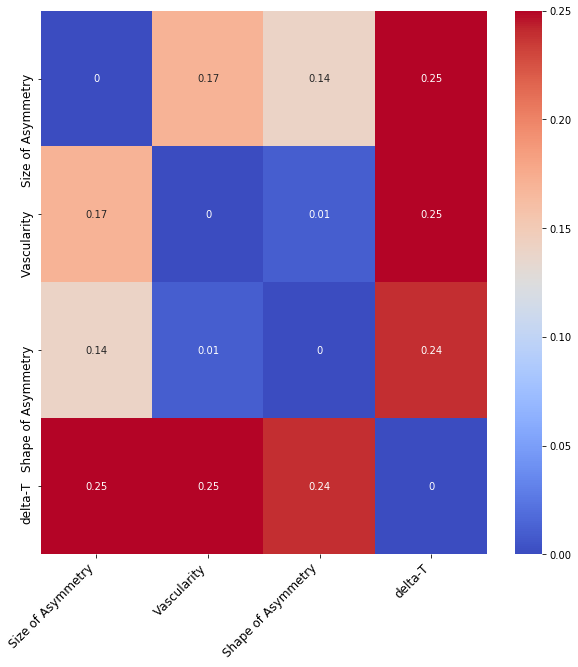

In [6]:
# Difference in feature correlation (Pearson)
diffs = (r1[['Size of Asymmetry', 
             'Vascularity', 
             'Shape of Asymmetry', 
             'delta-T']].corr()-r2[['Size of Asymmetry', 
                                    'Vascularity', 
                                    'Shape of Asymmetry', 
                                    'delta-T']].corr()).round(decimals=2)

# Transform into a heat map
fig = plt.figure(figsize=(10,10))
ax = sns.heatmap(diffs,annot=True, cmap='coolwarm')
plt.xticks(fontsize=12,rotation=45,ha='right')
plt.yticks(fontsize=12)
plt.xlabel("")
plt.ylabel("")
plt.show()

In [7]:
# Check correlation between two tables
table = r1.corrwith(r2, axis=0, method='pearson') #.sort_values(ascending=False)
table = pd.DataFrame(table, columns = ['Pearson'])
table['Spearman'] = r1.corrwith(r2, axis=0, method='spearman').values
table['MeanR1'] = r1.mean(axis=0).values
table['MeanR2'] = r2.mean(axis=0).values
table[table.index!='BIRADS']

,Pearson,Spearman,MeanR1,MeanR2
# Regions of Interest,0.251183,0.259318,0.947368,1.271930
Size of Asymmetry,0.343649,0.332453,2.614035,4.763158
Vascularity,0.274263,0.265181,1.701754,2.903509
Shape of Asymmetry,0.225547,0.212124,3.087719,6.236842
delta-T,0.623705,0.637002,1.371404,1.383421
Nipple Asymmetry,0.116482,0.116482,0.429825,0.736842
Breast Shape Asymmetry,0.241491,0.230806,1.885965,5.114035
Subjective,0.360434,0.380625,3.833333,7.114035


Nipple Asymmetry has the worst Pearson coefficient of around 0.12 (mild correlation.) 

The highest correlation is indicated by the column delta-T - around 0.6. That can be explained by the metric's objective nature. 

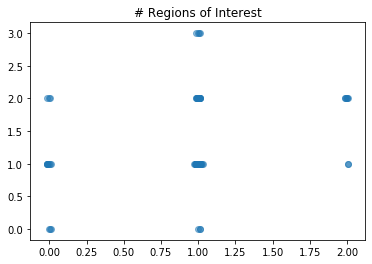

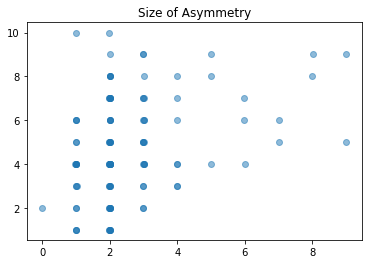

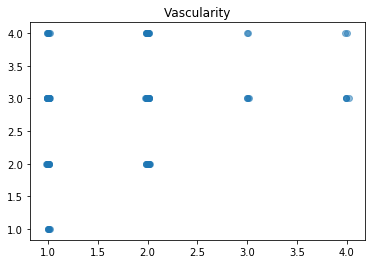

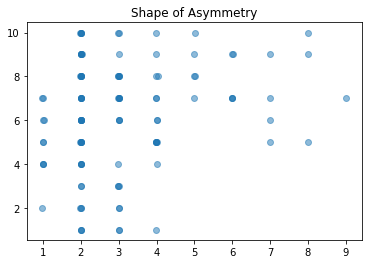

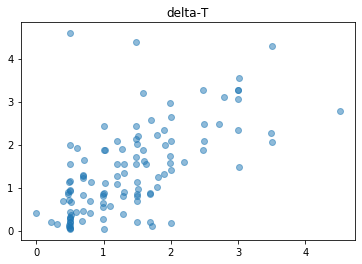

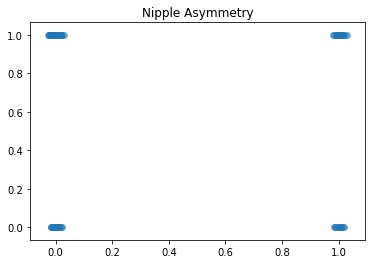

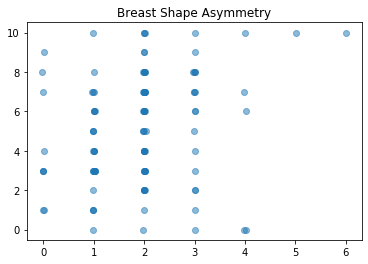

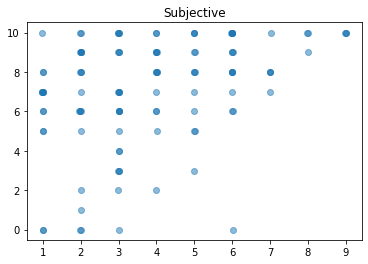

In [8]:
# Exploratory correlation plots
for column in r2.columns:
    if column != 'BIRADS':
        plt.scatter(r1[column].values + np.random.normal(0,0.01,len(r1)), r2[column].values, alpha=0.5)
        plt.title(column)
        plt.show()

### Combined Evaluations

In [9]:
# Try both mean or max
comb_avg = r1.copy()
comb_avg_max = r1.copy()
for column in r1.columns:
    comb_avg[column] = (r1[column].values + r2[column].values)/2.
    comb_avg_max[column] = [max(r1[column].values[i], 
                                r2[column].values[i]) for i in range(len(r1[column].values))]

### Thermal Scores

1) Thermal score from Gonzalez paper: the vascularity score with 4 values plus delta T.
2) VM Score from Keyserlingk based on the quantity of abnormal signs.
3) Subjective evaluation

In [10]:
# Define thermal scores
def get_therm_scores(r1):
    scores = pd.DataFrame({'Gonzalez':r1['Vascularity'] + r1['delta-T'],
                           'Subjective': r1['Subjective'],
                           'BIRADS': r1.BIRADS})
    return scores

scores_r1 = get_therm_scores(r1)
scores_r2 = get_therm_scores(r2)
scores_comb_avg = get_therm_scores(comb_avg)
scores_comb_max = get_therm_scores(comb_avg_max)

In [11]:
def hist_feature(feature, df):
    ''' Plot histograms colored by BIRADS.'''
    plt.hist(df[feature][df['BIRADS'] == 6], color = 'red',
             alpha = 0.5, density = False)
    plt.hist(df[feature][df['BIRADS'].isin([3,4])], color = 'orange',
             alpha = 0.5, density = False)
    plt.hist(df[feature][df['BIRADS'] <= 2], color = 'blue',
             alpha = 0.5, density = False)
    plt.title(feature)
    plt.show()
    return

In [12]:
# Load features, pids, and column names
os.chdir('../..')

pids = np.concatenate([np.load('data/aggregate/pids.npy', allow_pickle=True), 
                       np.load('data/aggregate/pids_test.npy', allow_pickle=True),
                       np.load('data/aggregate/pids_blind_test.npy', allow_pickle=True)])
features = np.concatenate([np.load('data/aggregate/feature_data.npy', allow_pickle=True), 
                           np.load('data/aggregate/feature_test.npy', allow_pickle=True),
                           np.load('data/aggregate/features_blind_test.npy', allow_pickle=True)])
columns = np.load('data/aggregate/feature_names.npy')

# Subset mean_diff required for the VM score
data = pd.DataFrame(features, columns=columns)
data['pids'] = pids
temp_diff = data[['mean_diff', 'pids']]

# Add column to the r1 and check for missing values
def add_mean_diff(df, temp_diff, pids):
    df_copy = df.copy()
    df_copy['pids'] = pids
    new_df = pd.merge(df_copy, temp_diff, on='pids', how='left')
    new_df[['pids', 'mean_diff']][np.isnan(new_df.mean_diff)]
    return new_df

new_r1 = add_mean_diff(r1, temp_diff, eval_pids)
new_r2 = add_mean_diff(r2, temp_diff, eval_pids)
new_comb_avg = add_mean_diff(comb_avg, temp_diff, eval_pids)
new_comb_max = add_mean_diff(comb_avg_max, temp_diff, eval_pids)

In [13]:
# Calculate the VM score
def get_VM(r1):
    scores = []
    for index, row in r1.iterrows():
        if row['Vascularity']<3:
            scores.append(np.ceil(row['Vascularity']))
            continue
        else:
            signs = 0
            # Sign 1
            if row['Vascularity'] > 2:
                signs += 1
            # Sign 2
            if row['Shape of Asymmetry'] > 5:
                signs+= 1
            # Sign 3
            if row['delta-T'] > 1:
                signs +=1
            # Sign 4
            if row['delta-T'] > 2:
                signs += 1
            # Sign 6
            if row['mean_diff'] > 1.5:
                signs += 1
        if signs == 1:
            scores.append(3)
        elif signs == 2:
            scores.append(4)
        elif signs >= 3:
            scores.append(5)
    return scores
        
scores_r1['Keyserlingk'] = get_VM(new_r1)
scores_r2['Keyserlingk'] = get_VM(new_r2)
scores_comb_avg['Keyserlingk'] = get_VM(new_comb_avg)
scores_comb_max['Keyserlingk'] = get_VM(new_comb_max)

## Score correlation

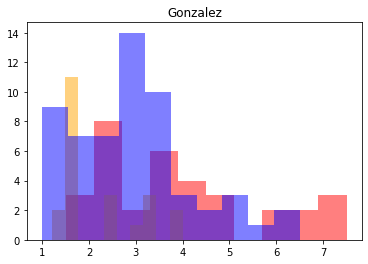

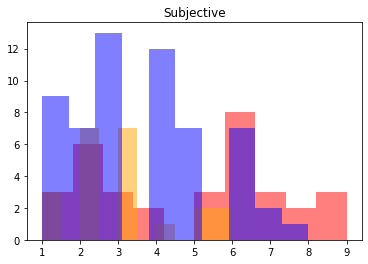

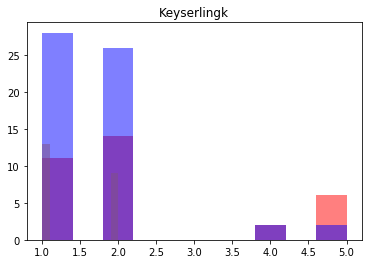

In [14]:
# Plot thermal scores
therm_plot = [hist_feature(ts, scores_r1) for ts in ['Gonzalez', 
                                                     'Subjective',
                                                     'Keyserlingk']]

In [15]:
score_table = scores_r1.corr().BIRADS

score_table = pd.DataFrame(score_table)
score_table.columns = ['R1']
score_table['R2'] =  scores_r2.corr().BIRADS.values
score_table['Both Mean'] =  scores_comb_avg.corr().BIRADS.values
score_table['Both Max'] =  scores_comb_max.corr().BIRADS.values
score_table
to_print = score_table[(score_table.index!='BIRADS')]
to_print.index = ['Gonzalez', 'Subjective', 'Keyserlingk']
to_print

,R1,R2,Both Mean,Both Max
Gonzalez,0.290213,0.351429,0.361505,0.355754
Subjective,0.252105,0.305510,0.340971,0.366800
Keyserlingk,0.250293,0.315799,0.231851,0.315367


The performance is comparable for both researchers, none of the scores seem to be significantly better than the other, but thermal_score1 is the leader for the full dataset. 

In [16]:
def find_threshold(target, pred, vis=False):
    """ Find the optimal threshold by maximizing specificity + sensitivity
    Parameters
    ----------
    target : Matrix with dependent or target data, where rows are observations

    pred : Matrix with predicted data, where rows are observations

    Returns
    -------     
    list type, with optimal cutoff value

    """
    fpr, tpr, threshold = metrics.roc_curve(target, pred)
    i = np.arange(len(tpr)) 
    if vis:
        roc = pd.DataFrame({'fpr' : pd.Series(fpr, index=i),
                                'tpr' : pd.Series(tpr, index = i), 
                                '1-fpr' : pd.Series(1-fpr, index = i), 
                                'tf' : pd.Series(tpr - (1-fpr), index = i), 
                                'thresholds' : pd.Series(threshold, index = i)})
        roc.ix[(roc.tf-0).abs().argsort()[:1]]

        # Plot tpr vs 1-fpr
        fig, ax = plt.subplots()
        plt.plot(roc['tpr'])
        plt.plot(roc['1-fpr'], color = 'red')
        plt.xlabel('1-False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Optimal Intersection')
        ax.set_xticklabels([])
        plt.show()
    roc = pd.DataFrame({'tf' : pd.Series(tpr-(1-fpr), index=i), 'threshold' : pd.Series(threshold, index=i)})
    roc_t = roc.ix[(roc.tf-0).abs().argsort()[:1]]

    return float(roc_t['threshold']) 

Gonzalez optimal threshold: 0.36
Keyserlingk optimal threshold: 0.5


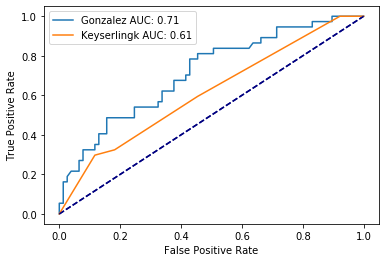

In [17]:
# Explore the best thresholds
def get_ROC(r1, vis=False):
    scores = r1.copy()
    scores['cancer'] = np.where(scores['BIRADS']>3, 1,0)
    scores = scores.drop(columns='BIRADS')
    gt = scores.cancer.values
    x = scores.values #returns a numpy array
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(x)
    scores = pd.DataFrame(x_scaled, columns=scores.columns)
    labels = ['Gonzalez', 'Keyserlingk']
    i=-1
    for column in scores.columns:
        if column != 'cancer' and column != 'Subjective':
            fpr, tpr, thresholds = metrics.roc_curve(gt, scores[column].values)
            thres = find_threshold(gt, scores[column].values, vis=False)
            print(str(column) +' optimal threshold: {0:0.2}'.format(thres))
            if vis:
                i+=1
                plt.plot(fpr,tpr, label=labels[i] + ' AUC: ' + str(round(metrics.roc_auc_score(gt, scores[column].values), 2)))
                plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
                plt.xlabel('False Positive Rate')
                plt.ylabel('True Positive Rate') 
            
            
            
        plt.legend()
        plt.plot()
    return

# Fer
get_ROC(scores_comb_avg, True)

## ML

A neural network can approach any arbitrary function (any combination of our features with any exponents and interaction terms) with enough layers. A single layer perceptron would approximate any linear combination of the features (acting like a logistic regression). An MLP with one hidden layer can result in any combination of features and multiplied pairs of features (which includes a feature squared). 

In [18]:
# Subset train and test sets
test_ind = np.random.rand(len(r1)) > 0.7
train = r1[~test_ind]
test = r1[test_ind]

In [19]:
# Train different models
mlp = MLP(hidden_layer_sizes = (5))
logreg = LogisticRegression()
rf = RandomForestClassifier()

mlp.fit(train.drop(dropcols, axis=1), train['BIRADS']==6)
logreg.fit(train.drop(dropcols, axis=1),train['BIRADS']==6)
rf.fit(train.drop(dropcols, axis=1),train['BIRADS']==6)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [20]:
# Create a copy of test to get predictions
# We need it because we add new columns to test
test_copy = test.drop(dropcols, axis=1)

In [21]:
test['preds_mlp'] = mlp.predict_proba(test_copy)[:,1]
test['preds_lr'] = logreg.predict_proba(test_copy)[:,1]
test['preds_rf'] = rf.predict_proba(test_copy)[:,1]

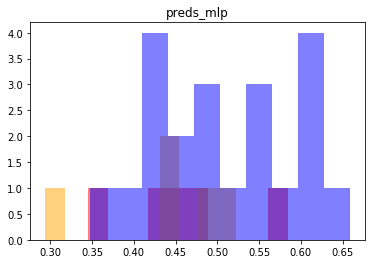

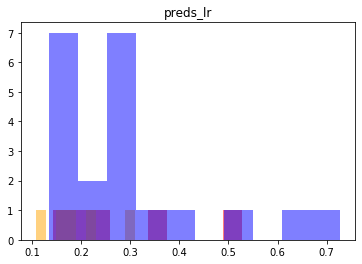

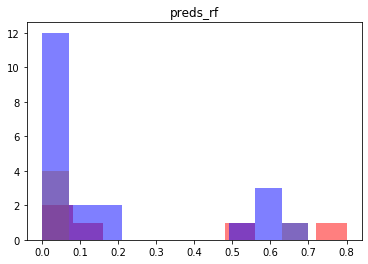

In [22]:
preds = [hist_feature(preds, test) for preds in  ['preds_mlp', 'preds_lr','preds_rf']]